In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.nn.functional import cosine_similarity

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:


# Load data
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

# Prepare dataset
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)



In [25]:
# Hyperparameters
hyperparameters = {
    # Data
    'fraction': 1,              # Fraction of training data to use (1%)
    'batch_size': 32,              # Batch size for training, validation, and test
    # Model Architecture
    'cnn_filters': [32, 64],       # Number of filters in CNN layers
    'cnn_kernel_size': (3, 3),     # Kernel size for CNN layers
    'cnn_padding': 1,              # Padding for CNN layers
    'lstm_hidden_size': 128,       # Hidden units per direction in LSTM
    'lstm_num_layers': 2,          # Number of LSTM layers
    'lstm_bidirectional': True,    # Whether LSTM is bidirectional
    'transformer_d_model': 256,     # Dimension of Transformer model
    'transformer_nhead': 4,         # Number of attention heads in Transformer
    'transformer_dim_feedforward': 512,  # Feedforward dimension in Transformer
    'transformer_num_layers': 2,    # Number of Transformer encoder layers
    'transformer_dropout': 0.1,     # Dropout rate in Transformer
    # Training
    'num_epochs': 50,              # Number of training epochs
    'learning_rate': 1e-3,         # Learning rate for Adam optimizer
    'loss_function': 'MSE',        # Loss function (Mean Squared Error)
}


In [18]:
# Normalize data
def normalize_data(X, y):
    X_mean = X.mean(dim=(0, 1), keepdim=True)
    X_std = X.std(dim=(0, 1), keepdim=True)
    X_norm = (X - X_mean) / (X_std + 1e-8)
    y_min = y.min(dim=1, keepdim=True)[0]
    y_max = y.max(dim=1, keepdim=True)[0]
    y_norm = 2 * (y - y_min) / (y_max - y_min + 1e-8) - 1
    return X_norm, y_norm, X_mean, X_std, y_min, y_max

def denormalize_y(y_norm, y_min, y_max):
    return (y_norm + 1) / 2 * (y_max - y_min + 1e-8) + y_min

# Assume data is loaded as X_train, y_train, etc.
X_train_norm, y_train_norm, X_train_mean, X_train_std, y_train_min, y_train_max = normalize_data(X_train, y_train)
X_val_norm, y_val_norm, X_val_mean, X_val_std, y_val_min, y_val_max = normalize_data(X_val, y_val)
X_test_norm, y_test_norm, X_test_mean, X_test_std, y_test_min, y_test_max = normalize_data(X_test, y_test)


In [19]:
# Subsample training data
def subsample_data(X, y, fraction=hyperparameters['fraction']):
    n_samples = X.shape[0]
    n_subsample = max(1, int(n_samples * fraction))
    indices = np.random.permutation(n_samples)[:n_subsample]
    return X[indices], y[indices]

X_train_sub, y_train_sub = subsample_data(X_train_norm, y_train_norm)
print(f"Subsampled training data: X_train_sub {X_train_sub.shape}, y_train_sub {y_train_sub.shape}")


Subsampled training data: X_train_sub torch.Size([91381, 320, 64]), y_train_sub torch.Size([91381, 320])


In [20]:
# Create DataLoaders
train_dataset = TensorDataset(X_train_sub, y_train_sub)
val_dataset = TensorDataset(X_val_norm, y_val_norm)
test_dataset = TensorDataset(X_test_norm, y_test_norm)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'])

In [26]:
# Define the hybrid model
class EEG2EnvModel(nn.Module):
    def __init__(self):
        super(EEG2EnvModel, self).__init__()
        # CNN Block
        self.cnn = nn.Sequential(
            nn.Conv2d(1, hyperparameters['cnn_filters'][0], kernel_size=hyperparameters['cnn_kernel_size'], 
                      padding=hyperparameters['cnn_padding']),
            nn.ReLU(),
            nn.BatchNorm2d(hyperparameters['cnn_filters'][0]),
            nn.Conv2d(hyperparameters['cnn_filters'][0], hyperparameters['cnn_filters'][1], 
                      kernel_size=hyperparameters['cnn_kernel_size'], padding=hyperparameters['cnn_padding']),
            nn.ReLU(),
            nn.BatchNorm2d(hyperparameters['cnn_filters'][1])
        )
        # LSTM Block
        self.lstm = nn.LSTM(input_size=hyperparameters['cnn_filters'][1]*64, 
                            hidden_size=hyperparameters['lstm_hidden_size'], 
                            num_layers=hyperparameters['lstm_num_layers'], 
                            batch_first=True, 
                            bidirectional=hyperparameters['lstm_bidirectional'])
        # Transformer Block
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hyperparameters['transformer_d_model'], 
                nhead=hyperparameters['transformer_nhead'], 
                dim_feedforward=hyperparameters['transformer_dim_feedforward'], 
                dropout=hyperparameters['transformer_dropout']
            ),
            num_layers=hyperparameters['transformer_num_layers']
        )
        # Output Layer
        self.fc = nn.Linear(hyperparameters['transformer_d_model'], 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # (N, 1, 320, 64)
        x = self.cnn(x)  # (N, 64, 320, 64)
        x = x.permute(0, 2, 1, 3).reshape(x.size(0), x.size(2), -1)  # (N, 320, 64*64)
        x, _ = self.lstm(x)  # (N, 320, 256)
        x = self.transformer(x)  # (N, 320, 256)
        x = self.fc(x).squeeze(-1)  # (N, 320)
        return x

model = EEG2EnvModel().to(device)
criterion = nn.MSELoss()  # Fixed to MSE as per hyperparameters['loss_function']
optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

# Metrics computation
def compute_metrics(y_true, y_pred):
    cosine_sims = []
    for i in range(y_true.shape[0]):
        cosine_sim = cosine_similarity(y_true[i].reshape(1, -1), y_pred[i].reshape(1, -1)).item()
        cosine_sims.append(cosine_sim)
    
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    mse = mean_squared_error(y_true_np.flatten(), y_pred_np.flatten())
    mae = mean_absolute_error(y_true_np.flatten(), y_pred_np.flatten())
    
    pearson_corrs = []
    for i in range(y_true_np.shape[0]):
        pearson, _ = pearsonr(y_true_np[i], y_pred_np[i])
        pearson_corrs.append(pearson if not np.isnan(pearson) else 0.0)
    
    return mse, mae, np.mean(pearson_corrs), np.mean(cosine_sims), pearson_corrs, cosine_sims

/DATAHDD/chailex/anaconda3/envs/mtech_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [27]:
# Training and validation loop
train_losses = []
val_losses = []
val_pearsons = []
val_cosines = []

for epoch in range(hyperparameters['num_epochs']):
    model.train()
    train_loss = 0
    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{hyperparameters["num_epochs"]} [Train]')
    for X_batch, y_batch in train_progress:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        train_progress.set_postfix({'loss': loss.item()})
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    val_mse, val_mae, val_pearson, val_cosine = 0, 0, 0, 0
    val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{hyperparameters["num_epochs"]} [Val]')
    with torch.no_grad():
        for X_batch, y_batch in val_progress:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            mse, mae, pearson, cosine, _, _ = compute_metrics(y_batch, outputs)
            val_mse += mse
            val_mae += mae
            val_pearson += pearson
            val_cosine += cosine
            val_progress.set_postfix({'loss': loss.item()})
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_pearsons.append(val_pearson / len(val_loader))
    val_cosines.append(val_cosine / len(val_loader))
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Val MSE: {val_mse/len(val_loader):.4f}, Val MAE: {val_mae/len(val_loader):.4f}, '
          f'Val Pearson: {val_pearson/len(val_loader):.4f}, Val Cosine: {val_cosine/len(val_loader):.4f}')


Epoch 1/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.01it/s, loss=0.319]


Epoch 1: Train Loss: 0.2719, Val Loss: 0.2596, Val MSE: 0.2596, Val MAE: 0.4309, Val Pearson: 0.1359, Val Cosine: 0.5705


Epoch 2/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.314]


Epoch 2: Train Loss: 0.2559, Val Loss: 0.2589, Val MSE: 0.2590, Val MAE: 0.4295, Val Pearson: 0.1520, Val Cosine: 0.5734


Epoch 3/50 [Val]: 100%|████████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.32]


Epoch 3: Train Loss: 0.2528, Val Loss: 0.2587, Val MSE: 0.2588, Val MAE: 0.4284, Val Pearson: 0.1559, Val Cosine: 0.5733


Epoch 4/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.323]


Epoch 4: Train Loss: 0.2493, Val Loss: 0.2592, Val MSE: 0.2593, Val MAE: 0.4264, Val Pearson: 0.1593, Val Cosine: 0.5744


Epoch 5/50 [Val]: 100%|████████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.32]


Epoch 5: Train Loss: 0.2440, Val Loss: 0.2615, Val MSE: 0.2616, Val MAE: 0.4317, Val Pearson: 0.1524, Val Cosine: 0.5692


Epoch 6/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.335]


Epoch 6: Train Loss: 0.2363, Val Loss: 0.2675, Val MSE: 0.2676, Val MAE: 0.4317, Val Pearson: 0.1447, Val Cosine: 0.5618


Epoch 7/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.322]


Epoch 7: Train Loss: 0.2265, Val Loss: 0.2724, Val MSE: 0.2724, Val MAE: 0.4371, Val Pearson: 0.1387, Val Cosine: 0.5505


Epoch 8/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.348]


Epoch 8: Train Loss: 0.2158, Val Loss: 0.2820, Val MSE: 0.2820, Val MAE: 0.4372, Val Pearson: 0.1313, Val Cosine: 0.5451


Epoch 9/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.348]


Epoch 9: Train Loss: 0.2055, Val Loss: 0.2893, Val MSE: 0.2894, Val MAE: 0.4411, Val Pearson: 0.1218, Val Cosine: 0.5365


Epoch 10/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.368]


Epoch 10: Train Loss: 0.1960, Val Loss: 0.2950, Val MSE: 0.2951, Val MAE: 0.4447, Val Pearson: 0.1196, Val Cosine: 0.5305


Epoch 11/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.355]


Epoch 11: Train Loss: 0.1878, Val Loss: 0.2962, Val MSE: 0.2963, Val MAE: 0.4466, Val Pearson: 0.1226, Val Cosine: 0.5208


Epoch 12/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.383]


Epoch 12: Train Loss: 0.1802, Val Loss: 0.3025, Val MSE: 0.3026, Val MAE: 0.4516, Val Pearson: 0.1143, Val Cosine: 0.5066


Epoch 13/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.38]


Epoch 13: Train Loss: 0.1734, Val Loss: 0.3071, Val MSE: 0.3072, Val MAE: 0.4541, Val Pearson: 0.1125, Val Cosine: 0.4999


Epoch 14/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.377]


Epoch 14: Train Loss: 0.1675, Val Loss: 0.3027, Val MSE: 0.3028, Val MAE: 0.4488, Val Pearson: 0.1144, Val Cosine: 0.5187


Epoch 15/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.39]


Epoch 15: Train Loss: 0.1617, Val Loss: 0.3110, Val MSE: 0.3110, Val MAE: 0.4529, Val Pearson: 0.1128, Val Cosine: 0.5106


Epoch 16/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.04it/s, loss=0.404]


Epoch 16: Train Loss: 0.1565, Val Loss: 0.3190, Val MSE: 0.3191, Val MAE: 0.4595, Val Pearson: 0.1103, Val Cosine: 0.4915


Epoch 17/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.397]


Epoch 17: Train Loss: 0.1518, Val Loss: 0.3187, Val MSE: 0.3188, Val MAE: 0.4579, Val Pearson: 0.1044, Val Cosine: 0.4990


Epoch 18/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.391]


Epoch 18: Train Loss: 0.1470, Val Loss: 0.3135, Val MSE: 0.3136, Val MAE: 0.4587, Val Pearson: 0.1039, Val Cosine: 0.4881


Epoch 19/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.408]


Epoch 19: Train Loss: 0.1427, Val Loss: 0.3286, Val MSE: 0.3287, Val MAE: 0.4644, Val Pearson: 0.1022, Val Cosine: 0.4830


Epoch 20/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.38]


Epoch 20: Train Loss: 0.1382, Val Loss: 0.3157, Val MSE: 0.3158, Val MAE: 0.4592, Val Pearson: 0.0984, Val Cosine: 0.4867


Epoch 21/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.384]


Epoch 21: Train Loss: 0.1342, Val Loss: 0.3247, Val MSE: 0.3247, Val MAE: 0.4646, Val Pearson: 0.0982, Val Cosine: 0.4745


Epoch 22/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.404]


Epoch 22: Train Loss: 0.1302, Val Loss: 0.3266, Val MSE: 0.3267, Val MAE: 0.4623, Val Pearson: 0.0999, Val Cosine: 0.4896


Epoch 23/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.423]


Epoch 23: Train Loss: 0.1263, Val Loss: 0.3287, Val MSE: 0.3288, Val MAE: 0.4657, Val Pearson: 0.0970, Val Cosine: 0.4749


Epoch 24/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.04it/s, loss=0.415]


Epoch 24: Train Loss: 0.1227, Val Loss: 0.3348, Val MSE: 0.3348, Val MAE: 0.4679, Val Pearson: 0.0934, Val Cosine: 0.4742


Epoch 25/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.418]


Epoch 25: Train Loss: 0.1193, Val Loss: 0.3433, Val MSE: 0.3434, Val MAE: 0.4729, Val Pearson: 0.0928, Val Cosine: 0.4639


Epoch 26/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.417]


Epoch 26: Train Loss: 0.1160, Val Loss: 0.3421, Val MSE: 0.3422, Val MAE: 0.4712, Val Pearson: 0.0957, Val Cosine: 0.4705


Epoch 27/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.415]


Epoch 27: Train Loss: 0.1129, Val Loss: 0.3466, Val MSE: 0.3467, Val MAE: 0.4749, Val Pearson: 0.0918, Val Cosine: 0.4604


Epoch 28/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.427]


Epoch 28: Train Loss: 0.1100, Val Loss: 0.3427, Val MSE: 0.3428, Val MAE: 0.4720, Val Pearson: 0.0924, Val Cosine: 0.4642


Epoch 29/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.411]


Epoch 29: Train Loss: 0.1073, Val Loss: 0.3377, Val MSE: 0.3377, Val MAE: 0.4691, Val Pearson: 0.0918, Val Cosine: 0.4722


Epoch 30/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.431]


Epoch 30: Train Loss: 0.1048, Val Loss: 0.3488, Val MSE: 0.3489, Val MAE: 0.4766, Val Pearson: 0.0881, Val Cosine: 0.4550


Epoch 31/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.43]


Epoch 31: Train Loss: 0.1023, Val Loss: 0.3481, Val MSE: 0.3481, Val MAE: 0.4768, Val Pearson: 0.0866, Val Cosine: 0.4534


Epoch 32/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.409]


Epoch 32: Train Loss: 0.1001, Val Loss: 0.3541, Val MSE: 0.3541, Val MAE: 0.4792, Val Pearson: 0.0888, Val Cosine: 0.4518


Epoch 33/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.425]


Epoch 33: Train Loss: 0.0979, Val Loss: 0.3552, Val MSE: 0.3553, Val MAE: 0.4784, Val Pearson: 0.0861, Val Cosine: 0.4621


Epoch 34/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.436]


Epoch 34: Train Loss: 0.0960, Val Loss: 0.3494, Val MSE: 0.3495, Val MAE: 0.4751, Val Pearson: 0.0883, Val Cosine: 0.4644


Epoch 35/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.428]


Epoch 35: Train Loss: 0.0941, Val Loss: 0.3504, Val MSE: 0.3505, Val MAE: 0.4778, Val Pearson: 0.0856, Val Cosine: 0.4513


Epoch 36/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.418]


Epoch 36: Train Loss: 0.0922, Val Loss: 0.3559, Val MSE: 0.3559, Val MAE: 0.4802, Val Pearson: 0.0841, Val Cosine: 0.4496


Epoch 37/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.419]


Epoch 37: Train Loss: 0.0906, Val Loss: 0.3530, Val MSE: 0.3531, Val MAE: 0.4789, Val Pearson: 0.0835, Val Cosine: 0.4513


Epoch 38/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.419]


Epoch 38: Train Loss: 0.0890, Val Loss: 0.3579, Val MSE: 0.3580, Val MAE: 0.4817, Val Pearson: 0.0844, Val Cosine: 0.4455


Epoch 39/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.423]


Epoch 39: Train Loss: 0.0876, Val Loss: 0.3651, Val MSE: 0.3652, Val MAE: 0.4855, Val Pearson: 0.0823, Val Cosine: 0.4418


Epoch 40/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.411]


Epoch 40: Train Loss: 0.0859, Val Loss: 0.3612, Val MSE: 0.3613, Val MAE: 0.4859, Val Pearson: 0.0783, Val Cosine: 0.4266


Epoch 41/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.429]


Epoch 41: Train Loss: 0.0846, Val Loss: 0.3567, Val MSE: 0.3568, Val MAE: 0.4807, Val Pearson: 0.0807, Val Cosine: 0.4502


Epoch 42/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.446]


Epoch 42: Train Loss: 0.0834, Val Loss: 0.3693, Val MSE: 0.3694, Val MAE: 0.4868, Val Pearson: 0.0818, Val Cosine: 0.4445


Epoch 43/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.424]


Epoch 43: Train Loss: 0.0821, Val Loss: 0.3609, Val MSE: 0.3609, Val MAE: 0.4825, Val Pearson: 0.0785, Val Cosine: 0.4496


Epoch 44/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.04it/s, loss=0.436]


Epoch 44: Train Loss: 0.0808, Val Loss: 0.3678, Val MSE: 0.3678, Val MAE: 0.4863, Val Pearson: 0.0801, Val Cosine: 0.4431


Epoch 45/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.43]


Epoch 45: Train Loss: 0.0799, Val Loss: 0.3637, Val MSE: 0.3637, Val MAE: 0.4857, Val Pearson: 0.0808, Val Cosine: 0.4350


Epoch 46/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.425]


Epoch 46: Train Loss: 0.0786, Val Loss: 0.3649, Val MSE: 0.3650, Val MAE: 0.4854, Val Pearson: 0.0814, Val Cosine: 0.4387


Epoch 47/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.463]


Epoch 47: Train Loss: 0.0776, Val Loss: 0.3769, Val MSE: 0.3770, Val MAE: 0.4913, Val Pearson: 0.0781, Val Cosine: 0.4357


Epoch 48/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.03it/s, loss=0.439]


Epoch 48: Train Loss: 0.0769, Val Loss: 0.3628, Val MSE: 0.3629, Val MAE: 0.4826, Val Pearson: 0.0800, Val Cosine: 0.4519


Epoch 49/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.04it/s, loss=0.444]


Epoch 49: Train Loss: 0.0759, Val Loss: 0.3684, Val MSE: 0.3684, Val MAE: 0.4874, Val Pearson: 0.0768, Val Cosine: 0.4369


Epoch 50/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.02it/s, loss=0.435]

Epoch 50: Train Loss: 0.0750, Val Loss: 0.3708, Val MSE: 0.3709, Val MAE: 0.4911, Val Pearson: 0.0788, Val Cosine: 0.4173


In [28]:
# Test evaluation with batch indexing
model.eval()
test_pearsons = []
test_cosines = []
test_predictions = []
test_trues = []
batch_start_idx = 0

with torch.no_grad():
    test_progress = tqdm(test_loader, desc='Testing')
    for X_batch, y_batch in test_progress:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        # Get batch-specific min/max
        batch_size = X_batch.size(0)
        batch_indices = slice(batch_start_idx, batch_start_idx + batch_size)
        y_min_batch = y_test_min[batch_indices].to(device)
        y_max_batch = y_test_max[batch_indices].to(device)
        # Denormalize
        outputs_denorm = denormalize_y(outputs, y_min_batch, y_max_batch)
        y_batch_denorm = denormalize_y(y_batch, y_min_batch, y_max_batch)
        # Compute metrics on normalized data
        _, _, _, _, pearson_corrs, cosine_sims = compute_metrics(y_batch, outputs)
        test_pearsons.extend(pearson_corrs)
        test_cosines.extend(cosine_sims)
        test_predictions.append(outputs_denorm.cpu().numpy())
        test_trues.append(y_batch_denorm.cpu().numpy())
        test_progress.set_postfix({
            'pred_min': outputs_denorm.min().item(),
            'pred_max': outputs_denorm.max().item(),
            'true_min': y_batch_denorm.min().item(),
            'true_max': y_batch_denorm.max().item()
        })
        batch_start_idx += batch_size

test_predictions = np.concatenate(test_predictions)
test_trues = np.concatenate(test_trues)

Testing: 100%|███████████| 788/788 [01:37<00:00,  8.05it/s, pred_min=0.14, pred_max=1.2, true_min=0.0779, true_max=1.51]


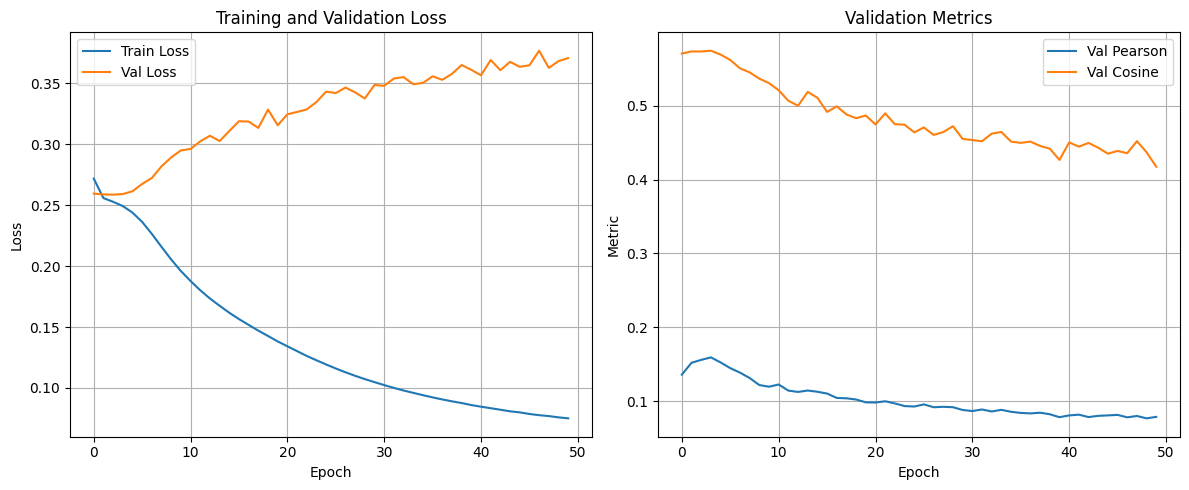

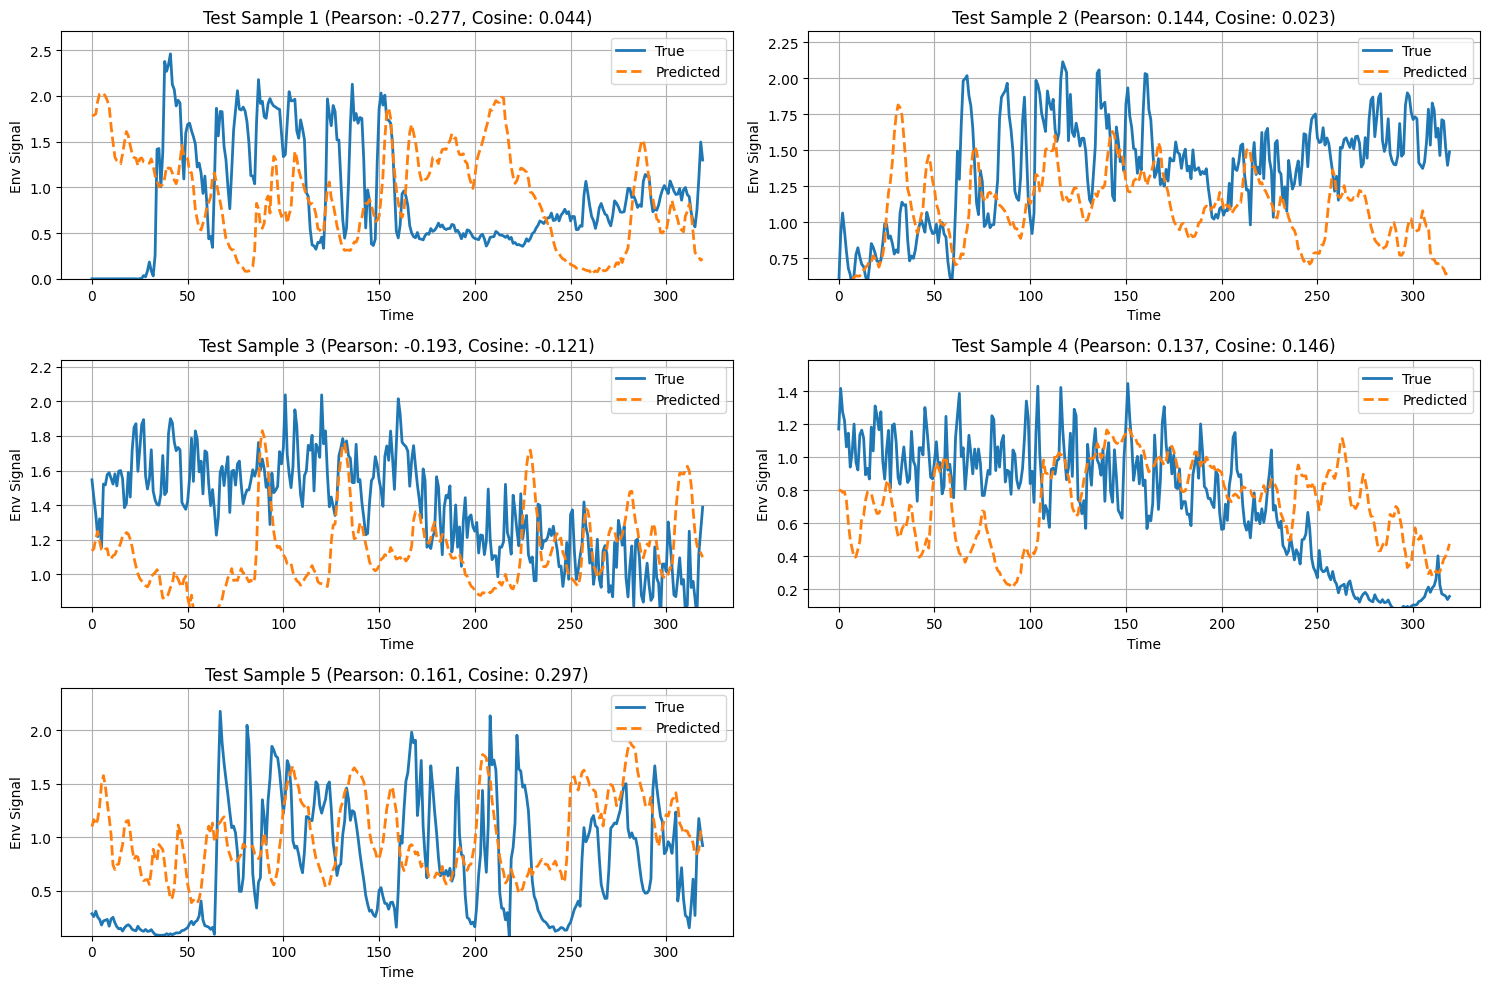

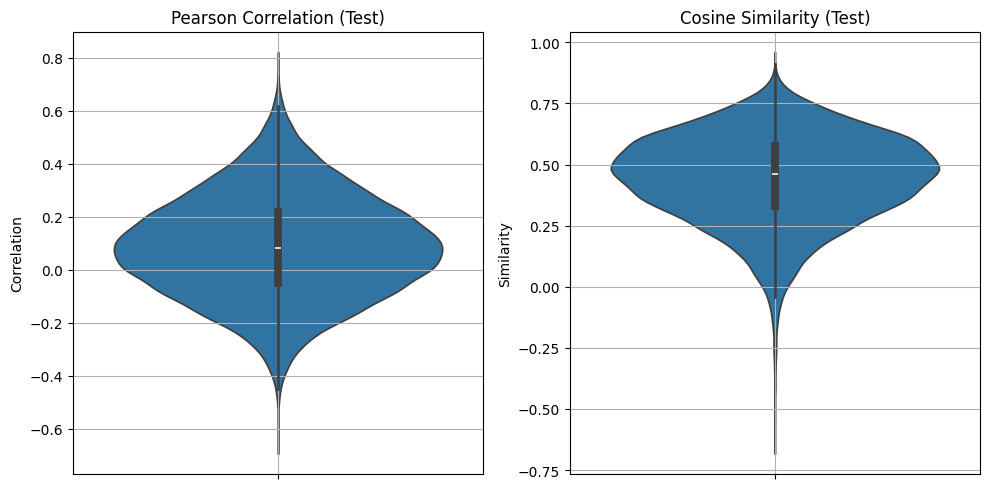

In [29]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_pearsons, label='Val Pearson')
plt.plot(val_cosines, label='Val Cosine')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Plot regression for 5 test samples
plt.figure(figsize=(15, 10))
for i in range(min(5, test_trues.shape[0])):
    plt.subplot(3, 2, i+1)
    plt.plot(test_trues[i], label='True', linewidth=2)
    plt.plot(test_predictions[i], label='Predicted', linestyle='--', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Env Signal')
    plt.title(f'Test Sample {i+1} (Pearson: {test_pearsons[i]:.3f}, Cosine: {test_cosines[i]:.3f})')
    plt.legend()
    plt.grid(True)
    y_min = min(test_trues[i].min(), test_predictions[i].min()) * 1.1
    y_max = max(test_trues[i].max(), test_predictions[i].max()) * 1.1
    plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('regression_plots.png')
plt.show()

# Violin plots for test metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.violinplot(data=test_pearsons)
plt.title('Pearson Correlation (Test)')
plt.ylabel('Correlation')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.violinplot(data=test_cosines)
plt.title('Cosine Similarity (Test)')
plt.ylabel('Similarity')
plt.grid(True)
plt.tight_layout()
plt.savefig('violin_plots.png')
plt.show()